In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import expm_multiply

In [2]:
# for saving figures saving figures
import os
os.makedirs("figures", exist_ok=True)


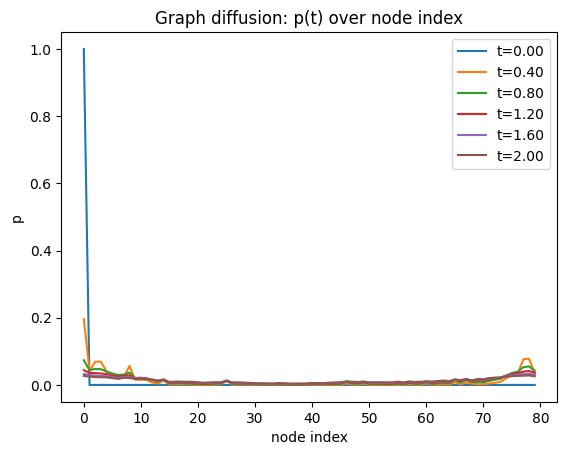

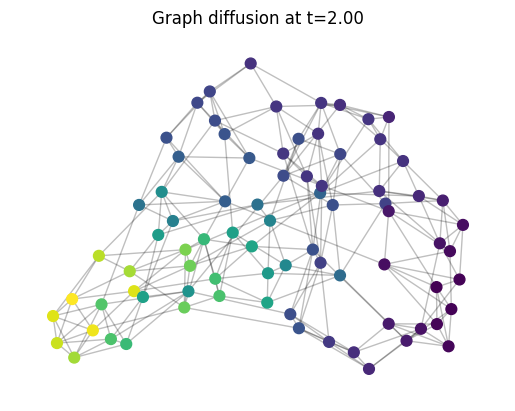

In [3]:
#We will be selecting Diffusion on a Graph via the equation dp/dt = -L*p
#L = D - A (A is adjacency and D is degree matrix) is the combinatorial Laplacian
#solution is of the form p(t) = exp(-Lt)p(0)
#Using random walk model, we'll compare graphs to see applications
#This here is just a sample for what will come later

def graph_laplacian_csr(G: nx.Graph) -> csr_matrix:
    """
    Combinatorial Laplacian L = D - A as a CSR sparse matrix.
    Node order is G.nodes() order; keeping this fixed for consistent indexing.
    """
    A = nx.to_scipy_sparse_array(G, format="csr", dtype=float)  # adjacency
    deg = np.asarray(A.sum(axis=1)).ravel()
    D = diags(deg, offsets=0, format="csr")
    return D - A


def diffuse_on_graph(G: nx.Graph, p0: np.ndarray, times: np.ndarray) -> np.ndarray:
    """
    Solve dp/dt = -L p with p(0)=p0 at specified times.
    Returns P with shape (len(times), n_nodes).
    """
    L = graph_laplacian_csr(G)
    p0 = np.asarray(p0, dtype=float)
    assert p0.ndim == 1 and p0.shape[0] == L.shape[0]

    # expm_multiply can compute exp(t*A)
    P = np.vstack([expm_multiply((-t) * L, p0) for t in times])

    # Numerical safety: clip tiny negatives and renormalize (optional)
    P[P < 0] = 0.0
    P = P / P.sum(axis=1, keepdims=True)
    return P


def demo():
    # Demo Graph
    #For this, we will use nx.path_graph(n), nx.grid_2d_graph(m,m), nx.watts_strogatz_graph(n,k,p), nx.barabasi_albert_graph(n,m)
    n = 80
    G = nx.watts_strogatz_graph(n=n, k=6, p=0.15, seed=1)

    # 2) Initial condition: delta at a single node (heat source)
    source = 0
    p0 = np.zeros(n)
    p0[source] = 1.0

    # 3) Diffuse
    times = np.linspace(0, 2.0, 6)
    P = diffuse_on_graph(G, p0, times)

    # 4) Plot the distribution over node index (for a general graph, index is arbitrary,
    #    but this is still a useful sanity check)
    plt.figure()
    for i, t in enumerate(times):
        plt.plot(P[i], label=f"t={t:.2f}")
    plt.title("Graph diffusion: p(t) over node index")
    plt.xlabel("node index")
    plt.ylabel("p")
    plt.legend()
    plt.show()

    # 5) Visualize on the graph layout
    pos = nx.spring_layout(G, seed=2)
    plt.figure()
    nx.draw_networkx_edges(G, pos, alpha=0.25)
    # color nodes by probability at final time
    p_final = P[-1]
    nx.draw_networkx_nodes(G, pos, node_size=60, node_color=p_final)
    plt.title(f"Graph diffusion at t={times[-1]:.2f}")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    demo()

In [4]:
#We start by calculating W, which I will use with Connor's code
#Using L = -W, I can then apply this to our diffusion equation
#We will also construct each lattice, again using Connor's code

#Simble Cubic Lattice
def sample_sc_lattice(a, size, prob):

    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    total_sites = Ncells  # 1 site per SC unit cell

    N_occupied = int(total_sites * prob)
    chosen_idx = np.random.choice(total_sites, N_occupied, replace=False)

    n_grid = len(grid_range)
    L = chosen_idx // (n_grid ** 2)
    M = (chosen_idx // n_grid) % n_grid
    N = chosen_idx % n_grid

    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]

    coords = np.stack([L, M, N], axis=1) * a
    return coords

#Body Centered Cubic Lattice
def sample_bcc_lattice(a, size, prob):

    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    total_sites = Ncells * 2  # 2 atoms per BCC unit cell

    N_occupied = int(total_sites * prob)
    chosen_idx = np.random.choice(total_sites, N_occupied, replace=False)

    unit_index = chosen_idx // 2
    basis_index = chosen_idx % 2

    n_grid = len(grid_range)
    L = unit_index // (n_grid**2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid

    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]
    coords_unit = np.stack([L, M, N], axis=1) * a

    basis = np.array([[0,0,0],[0.5,0.5,0.5]]) * a
    coords = coords_unit + basis[basis_index]

    return coords

#Face Centered Cubic Lattice
def sample_fcc_lattice(a, size, prob):
    """
    Create a face centered cubic (FCC) lattice with lattice constant "a."
    "size" is the number of unit cells along each axis.
    Dilute lattice sites according to probability "prob."
    """
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    total_sites = Ncells * 4  # 4 atoms per FCC unit cell

    N_occupied = int(total_sites * prob)
    chosen_idx = np.random.choice(total_sites, N_occupied, replace=False)

    unit_index = chosen_idx // 4
    basis_index = chosen_idx % 4

    n_grid = len(grid_range)
    L = unit_index // (n_grid**2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid

    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]
    coords_unit = np.stack([L, M, N], axis=1) * a

    basis = (a/2) * np.array([
        [0,0,0],
        [1,1,0],
        [1,0,1],
        [0,1,1]
    ])
    coords = coords_unit + basis[basis_index]

    return coords

#Diamond Lattice
def sample_diamond_lattice(a, size, prob):
    """
    Create a diamond lattice with lattice constant "a."
    "size" is the number of unit cells along each axis.
    Dilute lattice sites according to probability "prob."
    """
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    total_sites = Ncells * 8  # 8 atoms per diamond unit cell

    N_occupied = int(total_sites * prob)
    chosen_idx = np.random.choice(total_sites, N_occupied, replace=False)

    unit_index = chosen_idx // 8
    basis_index = chosen_idx % 8

    n_grid = len(grid_range)
    L = unit_index // (n_grid**2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid

    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]
    coords_unit = np.stack([L, M, N], axis=1) * a

    # Diamond basis (FCC + offset)
    fcc = (a/2) * np.array([
        [0,0,0],
        [1,1,0],
        [1,0,1],
        [0,1,1]
    ])
    offset = (a/4) * np.array([1,1,1])
    basis = np.vstack([fcc, fcc+offset])

    coords = coords_unit + basis[basis_index]
    return coords

In [5]:
#For the next step, we will calculate W and the Gillipse
#The combinatorial Laplacian takes on the form W = -L, which will we use for the Diffusion Equation
def calculate_W(a, size, lattice, nn_dist, A, alpha, nearest_neighbor=False):
    """
    calculate hopping/jumping rate matrix between sites. Strength given by A,
    for long-range coupling, power-law exponent is given by alpha.
    """

    N = lattice.shape[0] #total number of sites
    box_size = a * (2*size + 1)

    diff = lattice[:, None, :] - lattice[None, :, :]
    diff = diff - box_size * np.round(diff / box_size)
    dist = np.linalg.norm(diff, axis=2)

    np.fill_diagonal(dist, np.inf)

    if nearest_neighbor:
        mask = np.isclose(dist, nn_dist, atol=1e-6)
        W_off = np.zeros_like(dist)
        W_off[mask] = A
    else:
        with np.errstate(over='ignore', divide='ignore', invalid='ignore'):
            W_off = A / (dist**alpha)

    np.fill_diagonal(W_off, 0)
    col_sums = np.sum(W_off, axis=0)
    W = W_off - np.diag(col_sums)

    return W

#periodic distance and displacement (used for Gillespie)
def periodic_displacement(r2, r1, size, a):
    """
    Minimum-image displacement vector from r1 -> r2 under periodic BCs.
    """
    box_size = a * (2*size + 1)          # same as in calculate_W
    dr = np.asarray(r2) - np.asarray(r1)
    dr = dr - box_size * np.round(dr / box_size)
    return dr

def periodic_distance(r2, r1, size, a):
    """
    Minimum-image distance |r2 - r1| under periodic BCs.
    """
    dr = periodic_displacement(r2, r1, size, a)
    return float(np.linalg.norm(dr))


def gillespie(size, a, W, lattice, t_max, start_site=None):
    """
    Simulate random walk for one walker using gillespie algorithm.
    Randomly start on a site and sample next time step from an exponential probability distribution
    with mean given by total escape rate from that site. Then randomly jump to next site based on probability
    proportional to the hopping rate to that site. Then collect statistics.
    """

    N = W.shape[0]

    if start_site is None:
        site = np.random.randint(N)
    else:
        site = int(start_site)

    time = 0
    sites = [site]
    wait_times = []
    times = [0]

    while time < t_max:
        rates = W[:, site]
        total_rate = -W[site, site]
        if total_rate <= 0:
            break

        tau = np.random.exponential(1 / total_rate)
        time += tau

        probs = rates.copy()
        probs[site] = 0
        probs /= total_rate
        next_site = np.random.choice(N, p=probs)

        wait_times.append(tau)
        sites.append(next_site)
        times.append(time)
        site = next_site

    jump_lengths = [periodic_distance(lattice[sites[i+1]], lattice[sites[i]], size, a) for i in range(len(sites) - 1)]
    squared_displacements = [periodic_distance(lattice[sites[i]], lattice[sites[0]], size, a)**2 for i in range(len(sites))]

    visited = set()
    distinct_sites = []
    for s in sites:
        visited.add(s)
        distinct_sites.append(len(visited))

    return wait_times, jump_lengths, times, squared_displacements, distinct_sites, sites

In [6]:
#Distance Neighbors
def infer_nn_dist_pbc(lattice, box_size):
    """
    Infer nearest-neighbor distance from lattice coordinates using PBC.
    This avoids hard-coding nn_dist formulas for each lattice generator.
    """
    diff = lattice[:, None, :] - lattice[None, :, :]
    diff = diff - box_size * np.round(diff / box_size)
    dist = np.linalg.norm(diff, axis=2)
    np.fill_diagonal(dist, np.inf)
    nn = np.min(dist)
    return float(nn)

#Master Equation, i.e. p(t) = p(0)*exp(W*t)
def solve_master_equation(W, p0, t_grid):
    """
    Solve dp/dt = W p, p(t)=exp(W t)p0 for friend's column-sum-zero W.
    """
    Wsp = csr_matrix(W)
    P = np.vstack([expm_multiply(Wsp * t, p0) for t in t_grid])
    P[P < 0] = 0.0
    P /= P.sum(axis=1, keepdims=True)
    return P

#Sa
def sample_sites_on_grid(event_times, event_sites, t_grid):
    event_times = np.asarray(event_times)
    event_sites = np.asarray(event_sites)
    idx = np.searchsorted(event_times, t_grid, side="right") - 1
    idx = np.clip(idx, 0, len(event_sites) - 1)
    return event_sites[idx]

#Monte Carlo Estimate of p(t)
def empirical_p_from_gillespie(W, lattice, size, a, t_max, t_grid, n_walkers=2000, seed=0, start_site=0):
    """
    Monte Carlo estimate of p(t) from Gillespie trajectories, sampled on t_grid.
    """
    rng = np.random.default_rng(seed)
    N = W.shape[0]
    counts = np.zeros((len(t_grid), N), dtype=np.int64)

    for _ in range(n_walkers):
        # make Gillespie randomness reproducible across runs
        np.random.seed(rng.integers(0, 2**32 - 1))
        wait_times, jump_lengths, times, sq_disp, distinct, sites = gillespie(size, a, W, lattice, t_max, start_site=start_site)
        sites_on_grid = sample_sites_on_grid(times, sites, t_grid)
        counts[np.arange(len(t_grid)), sites_on_grid] += 1

    P_emp = counts / counts.sum(axis=1, keepdims=True)
    return P_emp

#Plotting distance versus time
def plot_predictability(t_grid, P_pred, P_emp, title, savepath=None):
    """
    Simple, interpretable predictability plot: L1 distance vs time.
    """
    l1 = np.sum(np.abs(P_emp - P_pred), axis=1)
    plt.figure()
    plt.plot(t_grid, l1)
    plt.xlabel("t")
    plt.ylabel(r"$\|p_{\mathrm{emp}}(t)-p_{\mathrm{pred}}(t)\|_1$")
    plt.title(title)
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

    plt.close()
    plt.show()


#Lattice Code
def run_lattice_case(lattice_name, lattice_fn,
                     a=1.0, size=6, prob=0.7,
                     A=1.0, alpha=3.0, nearest_neighbor=False,
                     t_max=5.0, n_time=51,
                     n_walkers=3000, seed=0,
                     start_site=0):
    """
    End-to-end:
      lattice -> nn_dist -> W -> exp(Wt)p0 -> Gillespie -> compare -> plot
    """
    # Build lattice
    lattice = lattice_fn(a=a, size=size, prob=prob)
    box_size = a * (2*size + 1)

    # Infer nn distance robustly
    nn_dist = infer_nn_dist_pbc(lattice, box_size)

    # Build W
    W = calculate_W(a, size, lattice, nn_dist, A, alpha, nearest_neighbor=nearest_neighbor)

    # Initial distribution
    N = W.shape[0]
    p0 = np.zeros(N)
    p0[start_site] = 1.0

    # Time grid
    t_grid = np.linspace(0.0, t_max, n_time)

    # Predicted (ensemble) distribution
    P_pred = solve_master_equation(W, p0, t_grid)

    # Empirical distribution from trajectories
    P_emp = empirical_p_from_gillespie(
      W, lattice, size, a, t_max, t_grid,
      n_walkers=n_walkers, seed=seed,
      start_site=start_site
      )


    # Plot predictability
    title = (f"{lattice_name} | prob={prob} | "
             f"{'NN' if nearest_neighbor else f'LR α={alpha}'} | "
             f"N={N} | walkers={n_walkers}")
    plot_predictability(
      t_grid, P_pred, P_emp,
      title,
      savepath=f"figures/predictability_{lattice_name.lower()}.png")

    return {
    "lattice": lattice,
    "nn_dist": nn_dist,
    "W": W,
    "t_grid": t_grid,
    "P_pred": P_pred,
    "P_emp": P_emp,
    "a": a,
    "size": size,
    "t_max": t_max,
    "start_site": start_site
    }


In [7]:
#Parameters
params = dict(
    a=1.0,
    size=6,
    prob=0.7,
    A=1.0,
    alpha=3.0,
    nearest_neighbor=True,
    t_max=5.0,
    n_time=51,
    n_walkers=3000,
    seed=1,
    start_site=0
)

# SC
out_sc = run_lattice_case("SC", sample_sc_lattice, **params)

# BCC
out_bcc = run_lattice_case("BCC", sample_bcc_lattice, **params)

# FCC
out_fcc = run_lattice_case("FCC", sample_fcc_lattice, **params)

# Diamond
out_dia = run_lattice_case("Diamond", sample_diamond_lattice, **params)

In [8]:
#Now that we have our predictibility curves, we can now simulate random walks that converge to the Diffusion Equation
#We can build an undirected NetworkX graph from the rate matrix W

def graph_from_W(W, max_edges_per_node=None, eps=0.0):
    """
    Build an undirected NetworkX graph from rate matrix W (your convention).
    Uses off-diagonal positive rates as edges.
    Optional: keep only top-k outgoing edges per node for readability.
    """
    N = W.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(N))

    W_off = W.copy()
    np.fill_diagonal(W_off, 0.0)

    if max_edges_per_node is None:
        # add all edges with rate > eps
        rows, cols = np.where(W_off > eps)
        for i, j in zip(rows, cols):
            if i < j:
                G.add_edge(i, j, weight=float(max(W_off[i, j], W_off[j, i])))
    else:
        # sparse: for each node j, keep top-k incoming rates W[i,j]
        for j in range(N):
            rates = W_off[:, j]
            idx = np.argpartition(rates, -max_edges_per_node)[-max_edges_per_node:]
            for i in idx:
                if rates[i] > eps and i != j:
                    a, b = (i, j) if i < j else (j, i)
                    G.add_edge(a, b, weight=float(max(W_off[a, b], W_off[b, a])))

    return G

#Layout
def pos_from_lattice_xy(lattice):
    """
    Use lattice coordinates for plotting: project to XY.
    """
    return {i: (float(lattice[i, 0]), float(lattice[i, 1])) for i in range(lattice.shape[0])}

#Plotting Diffusion with Random Walk
def plot_diffusion_with_walk(
    G, pos, P_pred, t_grid, t_plot,
    traj_sites=None, title="Diffusion + random walk overlay",
    savepath=None
):
    # find closest index in t_grid
    k = int(np.argmin(np.abs(t_grid - t_plot)))
    p = P_pred[k]
    c = np.log10(p + 1e-15)

    plt.figure(figsize=(9, 7))
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=40, node_color=c)

    if traj_sites is not None and len(traj_sites) > 1:
        path_xy = np.array([pos[s] for s in traj_sites])
        plt.plot(path_xy[:, 0], path_xy[:, 1], linewidth=2.0)      # path
        plt.scatter(path_xy[:, 0], path_xy[:, 1], s=18)            # steps
        plt.scatter(path_xy[0, 0], path_xy[0, 1], s=90, marker="o")# start
        plt.scatter(path_xy[-1, 0], path_xy[-1, 1], s=90, marker="X")# end

    plt.title(f"{title} | t≈{t_grid[k]:.2f}")
    plt.axis("off")
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

    plt.close()
    plt.show()

In [9]:
#Let us call our dictionary for the lattice and plot this.

out = out_dia

lattice = out["lattice"]
W = out["W"]
t_grid = out["t_grid"]
P_pred = out["P_pred"]
a = out["a"]
size = out["size"]
t_max = out["t_max"]
start_site = out["start_site"]

#Plotting
G = graph_from_W(W, eps=0.0)
pos = pos_from_lattice_xy(lattice)

wt, jl, times, r2, distinct, sites = gillespie(size, a, W, lattice, t_max, start_site=start_site)
plot_diffusion_with_walk(G, pos, P_pred, t_grid, t_plot=2.0, traj_sites=sites,
                         savepath="figures/diamond_diffusion_overlay_t2.png")


In [10]:
#Let's localize the plots to make this appear a bit more in depth
def induced_subgraph_around_path(G, sites, radius=2):
    keep = set(sites)
    frontier = set(sites)
    for _ in range(radius):
        nxt = set()
        for u in frontier:
            nxt.update(G.neighbors(u))
        keep |= nxt
        frontier = nxt
    return G.subgraph(keep).copy()

G_local = induced_subgraph_around_path(G, sites, radius=2)
pos_local = {n: pos[n] for n in G_local.nodes()}

# Filter P_pred to only include probabilities for nodes in G_local
P_pred_local_filtered = np.array([
    [P_pred_timestep[node] for node in G_local.nodes()]
    for P_pred_timestep in P_pred
])

plot_diffusion_with_walk(G_local, pos_local, P_pred_local_filtered, t_grid, t_plot=2.0, traj_sites=sites,
                         title="Local diffusion + walk overlay",
                         savepath = "fcc_diffusion_overlay_t2.png")